In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
from fastai.callbacks import *
import torch
import torch.nn.functional as F
from torch import nn

In [2]:
# Functions

Experiment = Enum('Experiment', 'exp1 exp2 exp3 exp4')
Method = Enum('Methods', 'noNNRestart noNNReval NNnorm NNdrop')
FuncName = Enum('FuncName', 'sphere rastrigin ackley rosenbrock')
DiversityMethod = Enum('DiversityMethod', 'RI Cw')

class DropoutModel(nn.Module):
    def __init__(self, d:int, w:int, nf:int, dropout:float=0.5):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        self.dropout = dropout
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(F.dropout(self.act(fts), p=self.dropout))

class SimpleModel(nn.Module):
    def __init__(self, d, w, nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(self.act(fts))

def get_functions(experiment:Experiment, D:int, func_name:FuncName)->Collection[Callable]:
    if func_name==FuncName.sphere:
        if experiment in [Experiment.exp1, Experiment.exp2]:
            def fitness_func(indiv, b, t): return (indiv.data**2).sum()
            def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
        elif experiment == Experiment.exp3:
            def fitness_func(indiv, b, t): return ((indiv.data + 0.1*t)**2).sum()
            def constraint_func(indiv, b, t): return 0
        elif experiment == Experiment.exp4:
            def fitness_func(indiv, b, t): return ((indiv.data-b[t]*np.sin(np.pi/2*t))**2).sum()
            def constraint_func(indiv, b, t): return 0
    elif func_name==FuncName.rastrigin:
        if experiment in [Experiment.exp1, Experiment.exp2]:
            def fitness_func(indiv, b, t): return 10*D+((indiv.data**2)-10*np.cos(2*np.pi*indiv.data)).sum()
            def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
        elif experiment == Experiment.exp3:
            def fitness_func(indiv, b, t): return 10*D+(((indiv.data+0.1*t)**2)-10*np.cos(2*np.pi*indiv.data)).sum()
            def constraint_func(indiv, b, t): return 0
        elif experiment == Experiment.exp4:
            def fitness_func(indiv, b, t): return 10*D+(((indiv.data-b[t]*np.sin(np.pi/2*t))**2)-10*np.cos(2*np.pi*indiv.data)).sum()
            def constraint_func(indiv, b, t): return 0                
    elif func_name==FuncName.rosenbrock:
        if experiment in [Experiment.exp1, Experiment.exp2]:
            def fitness_func(indiv, b, t): return ((100 * (indiv.data[1:] - indiv.data[:-1]**2)**2) + (1-indiv.data[:-1])**2).sum()
            def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)
        elif experiment == Experiment.exp3:
            def fitness_func(indiv, b, t): return ((100 * ((indiv.data[1:]+0.1*t) - (indiv.data[:-1]+0.1*t)**2)**2) + (1-indiv.data[:-1]-0.1*t)**2).sum()
            def constraint_func(indiv, b, t): return 0
        elif experiment == Experiment.exp4:
            def fitness_func(indiv, b, t): return (((100 * ((indiv.data[1:]-b[t]*np.sin(np.pi/2*t)) - (indiv.data[:-1]-b[t]*np.sin(np.pi/2*t))**2)**2) + (1-indiv.data[:-1]+b[t]*np.sin(np.pi/2*t))**2)).sum()
            def constraint_func(indiv, b, t): return 0  
    return fitness_func,constraint_func

def main(experiment:str, func_name:str, method:str, replace_mech:Optional[str]=None, D:int=30, runs:int=30, frequency:int=1,
         max_times:int=100, nn_window:int=5, nn_nf:int=4, nn_pick:int=3, nn_sample_size:int=1, save:bool=True, pbar:bool=True,
         silent:bool=True, cluster:bool=False, nn_train_window:Optional[int]=None, freq_save:int=1, batch_size:int=4,nn_epochs:int=10,
         dropout:float=0.5, diversity_method:Optional[str]=None):
    # Setting variables
    experiment_type = getattr(Experiment, experiment)
    method_type = getattr(Method, method)
    func_type = getattr(FuncName, func_name)
    path = Path(f'../../data/results/{experiment}/{func_name}')
    if cluster: path = Path(f'DENN/data/cluster_results/{experiment}/{func_name}') # this is for the cluster
    name = f'freq{freq_save}nn_w{nn_window}nn_p{nn_pick}nn_s{nn_sample_size}nn_tw{nn_train_window}nn_bs{batch_size}nn_epoch{nn_epochs}' #nn_s{nn_sample_size}nn_tw{nn_train_window}
    if diversity_method is not None:
        name += f'diversity{diversity_method}'
        diversity_method = DiversityMethod[diversity_method]
        
    out_path = path / name
    out_path.mkdir(parents=True, exist_ok=True)
    fitness_func,constraint_func = get_functions(experiment_type, D, func_type)
    is_nn = method_type in [Method.NNnorm, Method.NNdrop]
    experiment_name = f'{method}'
    total_generations = int(max_times * frequency * 1_000_000 + 1_000)
    if is_nn:
        experiment_name += f'_{replace_mech}'
        replace_type = getattr(ReplaceMechanism, replace_mech)

    # Read files
    if cluster:
        tmp_path = Path(f'DENN/data/results/{experiment}/{func_name}')
        ab = pd.read_csv(tmp_path/'dC_01.csv')['b'].values
        df = pd.read_csv(tmp_path/'best_known.csv')
        best_known_fitness = df['fitness'].values
        best_known_sumcv   = df['sum_constraints'].values
    else:
        ab = pd.read_csv(path/'dC_01.csv')['b'].values
        df = pd.read_csv(path/'best_known.csv')
        best_known_fitness = df['fitness'].values
        best_known_sumcv   = df['sum_constraints'].values

    # Initialize metrics
    results = {'mof':[], 'sr':[], 'nfe':[], 'fitness':[], 'sumcv':[], 'arr':[]}
    if is_nn: results['nn_time'] = []

    # Run
    it = progress_bar(range(runs)) if pbar else range(runs)
    for run in it:
        callbacks = []
        if is_nn:
            if method_type==Method.NNnorm:
                model = SimpleModel (d=D, w=nn_window, nf=nn_nf) 
                nn_trainer = partial(NNTrainer, model=model, n=nn_pick, sample_size=nn_sample_size, window=nn_window,
                                     train_window=nn_train_window, replace_mechanism=replace_type, bs=batch_size, epochs=nn_epochs)
            if method_type==Method.NNdrop:
                model = DropoutModel(d=D, w=nn_window, nf=nn_nf, dropout=dropout) 
                nn_trainer = partial(NNTrainerNoNoise  , model=model, n=nn_pick, sample_size=nn_sample_size, window=nn_window,
                                     train_window=nn_train_window, replace_mechanism=replace_type, bs=batch_size, epochs=nn_epochs)
            
            callbacks.append(nn_trainer)
        elif method_type==Method.noNNRestart:
            callbacks.append(OnChangeRestartPopulation)

        # Setting diversity method
        if diversity_method is None:
            evolve_mechanism = EvolveMechanism.Normal
        elif diversity_method == DiversityMethod.RI:
            evolve_mechanism = EvolveMechanism.Normal
            callbacks.append(RandomImmigrants)
        elif diversity_method == DiversityMethod.Cw:
            evolve_mechanism = EvolveMechanism.Crowding
        else: raise Exception(f'Invalid diversity method: {diversity_method}.')

        #first pop created here and passed to optimization
        population = Population.new_random(dimension=D)
        speed_metric = partial(SpeedMetric, threadhold=0.1)
        opt = Optimization(population, fitness_func, constraint_func, fitness_params=ab, constraint_params=[ab],
                           max_times=max_times, frequency=frequency, callbacks=callbacks,
                           metrics=[speed_metric, ModifiedOfflineError, OfflineError, AbsoluteRecoverRate],
                           optimal_fitness_values=best_known_fitness, optimal_sum_constraints=best_known_sumcv, evolve_mechanism=evolve_mechanism)
        return opt

# Random Immigrants

In [3]:
ri_opt = main('exp2', 'sphere', 'noNNReval', diversity_method='RI')

Total time: 01:41
SpeedMetric(success rate): 0.6400
ModifiedOfflineError: 0.1407
OfflineError: 0.1366
AbsoluteRecoverRate: 0.7645


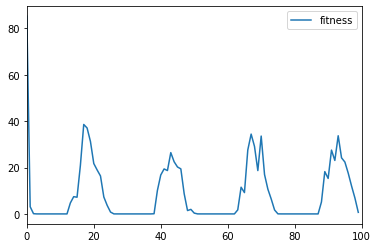

In [4]:
ri_opt.run(int(1e8))

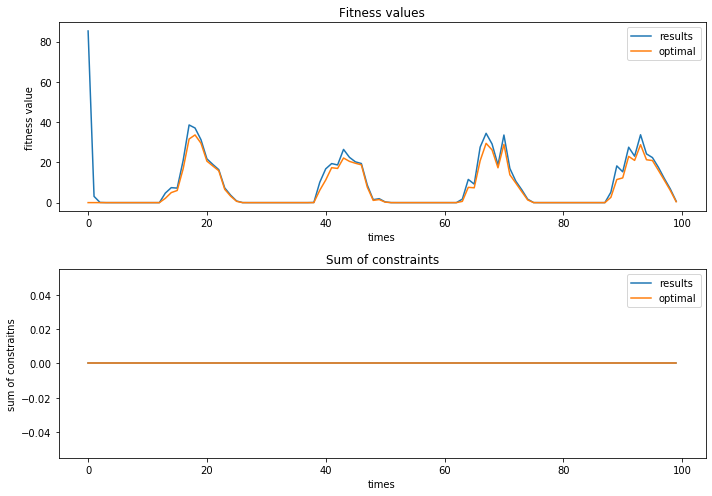

In [5]:
ri_opt.recorder.plot();

# Crowding

In [6]:
cw_opt = main('exp2', 'sphere', 'noNNReval', diversity_method='Cw')

Total time: 01:41
SpeedMetric(success rate): 0.3400
ModifiedOfflineError: 1.5419
OfflineError: 1.6244
AbsoluteRecoverRate: 0.1532


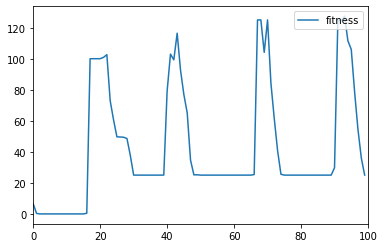

In [7]:
cw_opt.run(int(1e8))

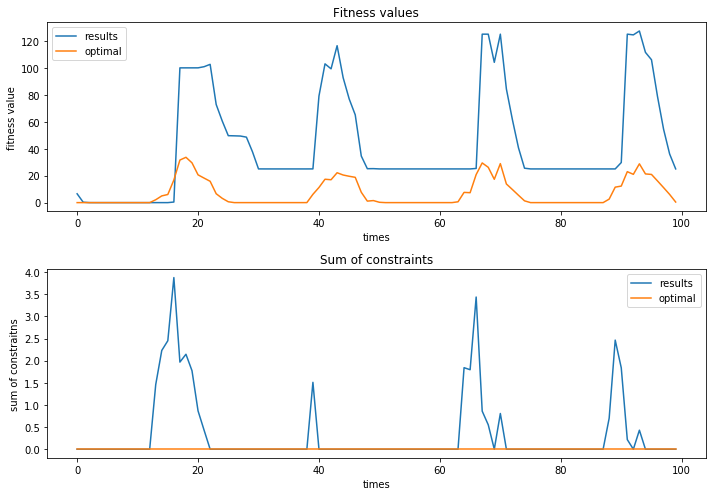

In [8]:
cw_opt.recorder.plot();

In [9]:
cw_opt.state_dict['gen']

8589

# Normal

In [10]:
opt = main('exp2', 'sphere', 'noNNReval', diversity_method=None)

Total time: 01:41
SpeedMetric(success rate): 0.8200
ModifiedOfflineError: 0.3839
OfflineError: 0.3893
AbsoluteRecoverRate: 0.5650


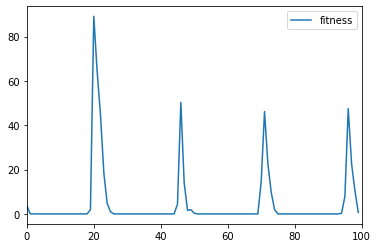

In [11]:
opt.run(int(1e8))

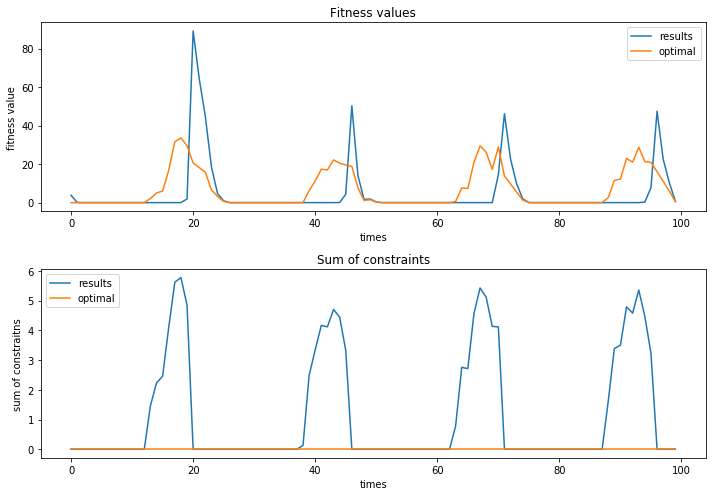

In [12]:
opt.recorder.plot();

In [13]:
opt.state_dict['gen']

11462